In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
from scipy import io
from statsmodels.stats.multitest import multipletests
from mne import viz
from matplotlib import colors, gridspec, pyplot as plt
from tqdm import tqdm

In [2]:
CAF_DOSE = 200 # the caffeine dose in mg (200 or 400)
AGE_GROUP = 0 # -1: all, 0: up to age 30, 1: from age 30

MIN_SLEEP_DROP_PCT = 100 # only look at subjects in the top MIN_SLEEP_DROP_PCT percent of caffeine induced sleep loss
USE_CAF_PLAC_DIFF = False # whether to correlate sleep duration with features using (CAF-PLAC) or directly
CONDITION = "ALL" # can be "ALL", "CAF" or "PLAC": decides which condition to correlate and show

SIGNIFICANT_P = 0.05 # weak significance threshold (grey dots)
SIGNIFICANT_P_STRONG = 0.01 # strong significance threshold (white dots)

PROJECT_PATH = 'data/' # path to where the EEG sensor position file is stored
FEATURE_PATH = f'data/Features{CAF_DOSE}/Combined' # path to precomputed features
SUBJECTS_PATH = f'data/CAF_{CAF_DOSE}_Inventaire.csv'

STAGES = ['NREM', 'REM'] # sleep stages to include in the figure

if USE_CAF_PLAC_DIFF:
    assert CONDITION == "ALL", "CONDITION must be \"ALL\" when USE_CAF_PLAC_DIFF is set to True"

In [3]:
subj_info = pd.read_csv(SUBJECTS_PATH, index_col=0)

if AGE_GROUP == 0:
    subj_info = subj_info[subj_info["Age"] < 30]
elif AGE_GROUP == 1:
    subj_info = subj_info[subj_info["Age"] >= 30]
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

# total sleep time (TST)
subj_info["sleep_epochs"] = subj_info[["N1 epochs", "N2 epochs", "N3 epochs", "REM epochs"]].sum(axis=1)

subj_info["subj_name"] = subj_info["Subject_id"].map(lambda x: x.lower().split("n")[0])
subj_info["label"] = (subj_info["CAF"] == "Y").astype(int)
subj_info.head()

,Subject_id,Number of EEG channels,EEG channel names,Sampling frequency,Montage rejet artefact,Total number of epochs,Rejected epochs,Awake epochs,N1 epochs,N2 epochs,N3 epochs,REM epochs,CAF,Gender,Age,sleep_epochs,subj_name,label
2,11001n1b,20,"[u'EEG Fp1', u'EEG Fp2', u'EEG F3', u'EEG F4',...",256,Montage1,1478,618,58,113,854,47,405,Y,M,20,1419,11001,1
3,11001n2,20,"[u'EEG Fp1', u'EEG Fp2', u'EEG F3', u'EEG F4',...",256,Montage1,1478,553,98,172,968,24,215,N,M,20,1379,11001,0
4,11002n1,20,"[u'EEG Fp1', u'EEG Fp2', u'EEG F3', u'EEG F4',...",256,Montage1,1498,329,144,153,911,10,276,N,F,23,1350,11002,0
5,11002n2,20,"[u'EEG Fp1', u'EEG Fp2', u'EEG F3', u'EEG F4',...",256,Montage1,1519,352,452,138,663,8,257,Y,F,23,1066,11002,1
10,11006n1,20,"[u'EEG Fp1', u'EEG Fp2', u'EEG F3', u'EEG F4',...",256,Montage1,1499,245,134,110,854,67,333,Y,M,22,1364,11006,1


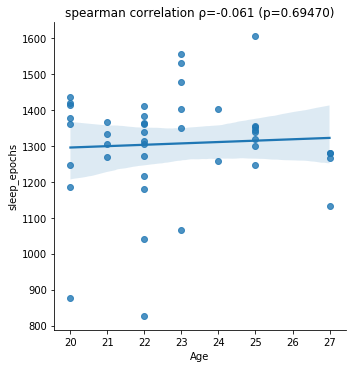

In [4]:
corr = spearmanr(subj_info["Age"], subj_info["sleep_epochs"])
sns.lmplot(x="Age", y="sleep_epochs", data=subj_info)
plt.title(f"spearman correlation ρ={corr.correlation:.3f} (p={corr.pvalue:.5f})")
plt.show()

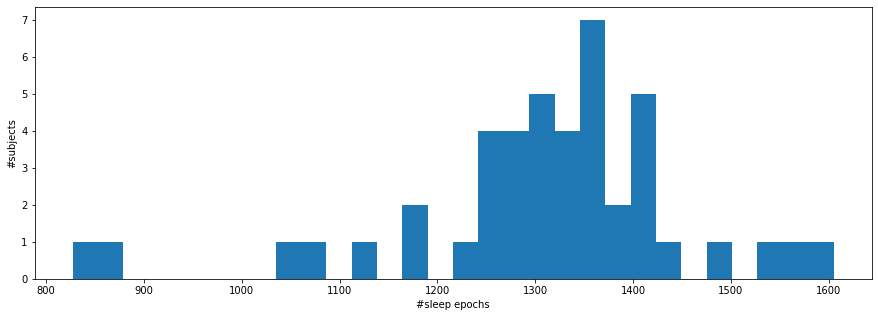

In [5]:
plt.figure(figsize=(15, 5))
subj_info["sleep_epochs"].plot(kind="hist", bins=30)
plt.xlabel("#sleep epochs")
plt.ylabel("#subjects")
plt.show()

In [6]:
# get age suffix for loading the data depending on age group parameter
age_suffix = ''
if AGE_GROUP == 0:
    age_suffix = '_age_t30'
elif AGE_GROUP == 1:
    age_suffix = '_age_f30'
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

# load computed features
with open(os.path.join(FEATURE_PATH, f'data_avg{age_suffix}.pickle'), 'rb') as file:
    data = pickle.load(file)

# load corresponding labels to the features
with open(os.path.join(FEATURE_PATH, f'labels_avg{age_suffix}.pickle'), 'rb') as file:
    labels = pickle.load(file)

# load subject group vectors
with open(os.path.join(FEATURE_PATH, f'groups_avg{age_suffix}.pickle'), 'rb') as file:
    groups = pickle.load(file)

# load group-subject_id mapping
with open(os.path.join(FEATURE_PATH, f'groups_names{age_suffix}.pickle'), 'rb') as file:
    group_names = pickle.load(file)
    
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [7]:
"""
# load computed features
with open(os.path.join(FEATURE_PATH, f'data.pickle'), 'rb') as file:
    data = pickle.load(file)

# load corresponding labels to the features
with open(os.path.join(FEATURE_PATH, f'labels.pickle'), 'rb') as file:
    labels = pickle.load(file)

# load subject group vectors
with open(os.path.join(FEATURE_PATH, f'groups.pickle'), 'rb') as file:
    groups = pickle.load(file)

# load group-subject_id mapping
with open(os.path.join(FEATURE_PATH, f'groups_names.pickle'), 'rb') as file:
    group_names = pickle.load(file)
"""

"\n# load computed features\nwith open(os.path.join(FEATURE_PATH, f'data.pickle'), 'rb') as file:\n    data = pickle.load(file)\n\n# load corresponding labels to the features\nwith open(os.path.join(FEATURE_PATH, f'labels.pickle'), 'rb') as file:\n    labels = pickle.load(file)\n\n# load subject group vectors\nwith open(os.path.join(FEATURE_PATH, f'groups.pickle'), 'rb') as file:\n    groups = pickle.load(file)\n\n# load group-subject_id mapping\nwith open(os.path.join(FEATURE_PATH, f'groups_names.pickle'), 'rb') as file:\n    group_names = pickle.load(file)\n"

In [8]:
feature_names = set()
result = {}
for stage in STAGES:
    result[stage] = {}
    g_stage = "N1" if stage == "NREM" else stage
    for feature in tqdm(data[stage].keys(), desc=f"stage {stage}"):
        result[stage][feature] = {"sleep_duration": [], "feature": []}
        
        name = f"{stage}-{feature}"
        feature_names.add(name)
        for d, l, g in zip(data[stage][feature], labels[stage], groups[stage]):
            if CONDITION == "CAF" and l == 0:
                # we only want CAF but this is PLAC so skip
                continue
            elif CONDITION == "PLAC" and l == 1:
                # we only want PLAC but this is CAF so skip
                continue
            
            mask = ((subj_info["subj_name"] == group_names[g_stage][g]) & (subj_info["label"] == l))
            sleep_dur = subj_info.loc[mask,"sleep_epochs"].values
            assert len(sleep_dur) == 1
            sleep_dur = sleep_dur[0]

            result[stage][feature]["sleep_duration"].append(sleep_dur)
            result[stage][feature]["feature"].append(d)

        result[stage][feature]["sleep_duration"] = np.array(result[stage][feature]["sleep_duration"])
        result[stage][feature]["feature"] = np.array(result[stage][feature]["feature"])
        
        if USE_CAF_PLAC_DIFF:
            # compute differences in sleep duration to potentially include only e.g. 25% strongest drops
            total_duration_differences = []
            for g in np.unique(groups[stage]):
                group_mask = groups[stage] == g
                caf_mask = labels[stage][group_mask] == 1
                total_duration_differences.append(result[stage][feature]["sleep_duration"][group_mask][caf_mask]
                                                  - result[stage][feature]["sleep_duration"][group_mask][~caf_mask])
            total_duration_differences = np.array(total_duration_differences).squeeze()

            # compute differences between CAF and PLAC for sleep durations and features
            # potentially drop subjects with less pronounced caffeine induced decrease in sleep duration
            sleep_dur_diff = []
            feature_diff = []
            for g in np.unique(groups[stage]):
                group_mask = groups[stage] == g
                caf_mask = labels[stage][group_mask] == 1

                # drop subjects with less pronounced caffeine induced drop in sleep duration
                curr_sleep_dur_diff = (result[stage][feature]["sleep_duration"][group_mask][caf_mask]
                                       - result[stage][feature]["sleep_duration"][group_mask][~caf_mask])
                if curr_sleep_dur_diff > np.percentile(total_duration_differences, MIN_SLEEP_DROP_PCT):
                    continue

                sleep_dur_diff.append(curr_sleep_dur_diff)
                feature_diff.append(result[stage][feature]["feature"][group_mask][caf_mask]
                                    - result[stage][feature]["feature"][group_mask][~caf_mask])
            result[stage][feature]["sleep_duration_diff"] = np.array(sleep_dur_diff).squeeze()
            result[stage][feature]["feature_diff"] = np.array(feature_diff).squeeze()
        
feature_names = sorted(list(feature_names))

stage REM: 100%|██████████| 18/18 [00:00<00:00, 48.76it/s]


In [9]:
for stage in STAGES:
    print(f"{stage}: number of samples {result[stage]['PSD_delta']['feature'].shape[0]}")

AWSL: number of samples 40
NREM: number of samples 44
REM: number of samples 44


In [10]:
for stage in result.keys():
    for feature in result[stage].keys():
        num_elecs = result[stage][feature]["feature"].shape[1]
        result[stage][feature]["corr"] = np.full(num_elecs, float("nan"))
        result[stage][feature]["pval"] = np.full(num_elecs, float("nan"))
        for elec in range(num_elecs):
            suffix = "_diff" if USE_CAF_PLAC_DIFF else ""
            corr = spearmanr(result[stage][feature]["sleep_duration" + suffix],
                             result[stage][feature]["feature" + suffix][:,elec])
            result[stage][feature]["corr"][elec] = corr.correlation
            result[stage][feature]["pval"][elec] = corr.pvalue
        
        # TODO: choose correct method for multiple comparison correction
        result[stage][feature]["pval"] = multipletests(result[stage][feature]["pval"], method="fdr_bh")[1]

<ipython-input-11-8a734e2c1e3e>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  marker_colors = np.array(marker_colors)[mask]
<ipython-input-11-8a734e2c1e3e>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  marker_colors = np.array(marker_colors)[mask]
<ipython-input-11-8a734e2c1e3e>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

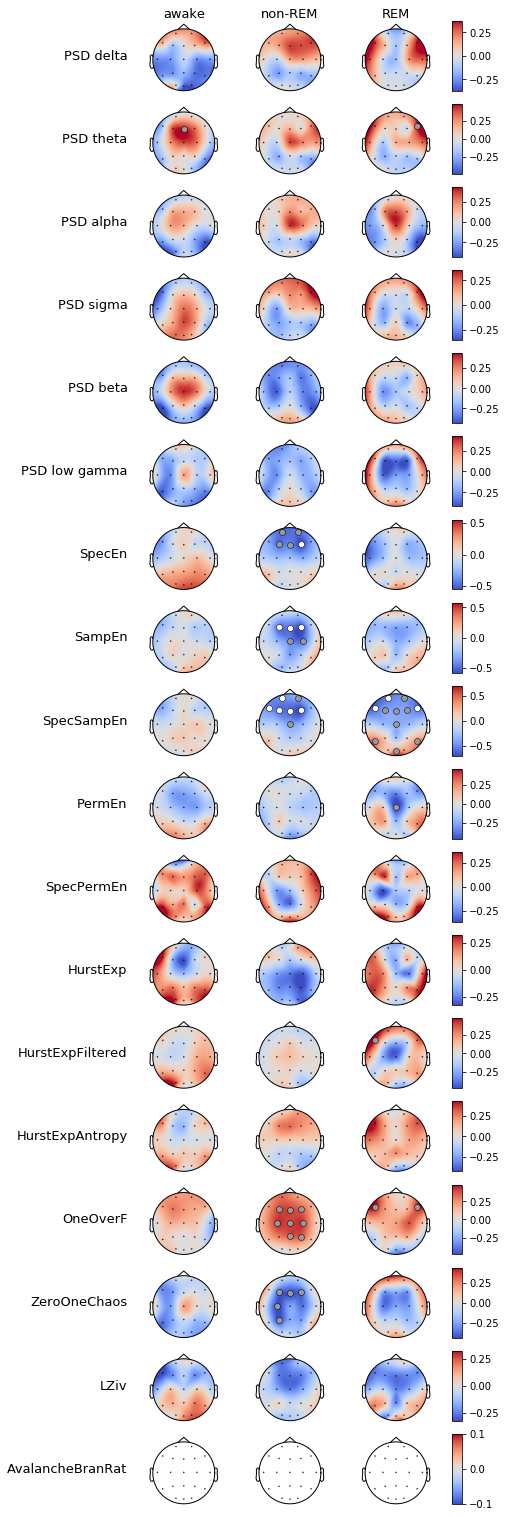

In [11]:
fontsize_small = 13
fontsize_big = 20
colormap = 'coolwarm'

width = len(STAGES)
height = len(result[STAGES[0]])

# create gridspec
gs = gridspec.GridSpec(height + 1,
                       width + 2,
                       width_ratios=[0.001] + [1] * width + [0.1],
                       height_ratios=[0.01] + [1] * height,
                       wspace=0.1)
subplot_counter = 1
plt.figure(figsize=(6, height * 1.4))
feature_labels = []

# add stage annotations
for stage in STAGES:
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    feature_labels.append(plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                                       xy=(0.5, 0),
                                       ha='center',
                                       va='top',
                                       fontsize=fontsize_small))
    plt.axis('off')
subplot_counter += 1

for feature in result[STAGES[0]].keys():
    # add feature annotations
    plt.subplot(gs[subplot_counter])
    subplot_counter += 1
    
    name = feature.replace('_', ' ').replace('SpecShanEn', 'SpecEn')
    feature_labels.append(plt.annotate(name, xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small))
    plt.axis('off')
    
    # get min and max values for plots and colorbars
    vmin = np.min([np.min(result[stage][feature]['corr']) for stage in STAGES])
    vmax = np.max([np.max(result[stage][feature]['corr']) for stage in STAGES])
    absolute = max(abs(vmin), abs(vmax))
    vmin = -absolute
    vmax = absolute

    axes = []
    for stage in STAGES:
        axes.append(plt.subplot(gs[subplot_counter]))
        subplot_counter += 1
        
        # get significance marker params
        mask = result[stage][feature]['pval'] < SIGNIFICANT_P
        marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
        for i in np.where(result[stage][feature]['pval'] < SIGNIFICANT_P_STRONG)[0]:
            marker_colors[i] = 'w'
        marker_colors = np.array(marker_colors)[mask]
        
        # plot topomaps
        viz.plot_topomap(result[stage][feature]['corr'],
                         sensor_pos,
                         mask=mask,
                         vmin=vmin,
                         vmax=vmax,
                         mask_params={'markersize': 6, 'markeredgewidth': 0.5, 'markerfacecolor': marker_colors},
                         cmap=colormap,
                         contours=False,
                         show=False)
    
    # add colorbar
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=plt.subplot(gs[subplot_counter]))
    subplot_counter += 1
    
plt.show()